In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile

In [2]:
dx = 200
dt = 1.0
t_total = 1000
timesteps =int(t_total/dt)
yrs=np.arange(0, timesteps+1, 1)
x_m = 20000.0
x_s = 7000.0 #bed length
x = np.arange(0.0,x_m + x_m/2.0 + dx,dx, dtype='int64')
x_trib = np.arange(0.0,x[16] + dx,dx, dtype='int64')
Nx = len(x)
interval = t_total/50. #timesteps that are graphed

b_0 = 500.0 #cliff base height

mdot_0 = 2.0 #initial accumulation

# coefficients
A = 1.0e-16 
n = 3.0
g = 9.81 #m/s^2
rho = 910.0
Gamma = 2.0*A*(rho*g)**n/(n+2)
c_stab = 0.165

B = np.zeros(Nx) #Bed Vector
#B[x<x_s]=b_0

SEC_IN_YEAR = 31536000
mdot_con = 10. #mb (mm/yr)

Set the shallow ice solving methods you want to use to 1 and all other others to 0

Set the limiter you want to use to one and the other to 0

In [3]:
# numberical Methods
use_E = 0 #Euler
use_TVD = 1 #TVD runge Kutta Method
use_nTVD = 0 #Non TVD Runge Kutta Method

#needs to be added
use_minmod = 0 #minmod function
use_superbee = 1 #superbee function

#shallow ice solving method
use_MUSCL = 0
use_M2 = 1
use_M3 = 0
use_upstream = 0

#bed
use_cliff = 0
use_hill = 0
use_flowlines = 1

#Mass Balance
use_steadyState = 1
use_constant = 0

#Plots
#Time Evolution length
plt_TEL = 0
#Time Evolution Volume
plt_TEV = 0
#Surface elevation
plt_SE = 0
#Surface Width
plt_SW = 0

In [4]:
#bed
if use_cliff ==1:
    B[x<x_s]=b_0
    #print(len(B))
if use_hill == 1:
    x0 = np.linspace(3000.,1000.,Nx)
    B = B + x0
    #print(B)
    
if use_flowlines ==1:
    x0 = np.linspace(3000.,1000.,Nx)
    B = B + x0
    Nxt = len(x_trib)
    trib=np.zeros(Nxt)
    trib0 = np.linspace(3000.,B[50],Nxt)
    trib = trib + trib0

In [5]:
# standard minmod functioin
def minmod(a,b):
    sign = (np.sign(a)+np.sign(b))
    minmod = sign/2*(np.minimum(np.abs(a), np.abs(b)))
    return minmod

def superbee(r):
    #r = (H-Hm)/(Hp-H) #gives divide by 0 errors, makes sense when the height of the glacier is 0
    superbee =np.maximum(0,np.minimum(2*r,1), np.minimum(r,2)) 
    return superbee

# flux
def flux(s1, s2):
    flux = ((s1-s2)**2. / dx**2.)**((n-1.)/2.)
    return flux

# Shallow Ice approximation
def L(Dup,Sup, S, Ddn, Sdn):
    L=(Dup * (Sup - S)/dx - Ddn * (S - Sdn)/dx)/dx #equation 36 Jarosh 2013
    return L


# index
def H_index(h, h2):
    H_index = 0.5*(h+h2)
    return H_index

# H up index
def H_plus(H, Hp, H2p):
    if use_minmod == 1:
        H_plus = Hp - 0.5*minmod((Hp-H), (H2p-Hp) )*(H2p-Hp)
    if use_superbee == 1:
        H_plus = Hp - 0.5*superbee(Hp ,H, H2p)*(H2p-Hp)
    return H_plus

# H down index
def H_min(H, Hm, Hp):
    if use_minmod == 1:
        H_min = H + 0.5*minmod((H-Hm), (Hp-H))*(Hp-H)
    if use_superbee == 1:
        H_min = H + 0.5*superbee(H,Hm,Hp)*(Hp-H)
    return H_min  
    
# Methods    
# Euler
def E(u, Lu, deltat):
    E = u-deltat*Lu
    return E

# TVD second order Runge-Kutta method
def TVDu1(u, Lu, deltat):
    TVDu1 = u+deltat*Lu
    return TVDu1

def TVD(u, Lu, L1, deltat):
    TVD = u+(0.5)*deltat*Lu+1/2*deltat*L1
    return TVD

# non TVD Runge-Kutta method method
def nTVDu1(u, Lu, deltat):
    nTVDu1 = u-20*deltat*Lu
    return nTVDu1

def nTVD(u, Lu, L1, deltat):
    nTVD = u+(41.0/40.0)*deltat*Lu-1.0/40.0*deltat*L1
    return nTVD

def accumulation(x,mdot_0,n,x_m):
    
    mdot = ((n*mdot_0)/(x_m**(2.*n-1.)))*x**(n-1.)*(abs(x_m-x)**(n-1.))*(x_m-2.*x) # Eq. 54 Jarosch 2013 
    mdot[x>x_m] = 0.
    return mdot
    
def diffusivisty(S1, S2, H1, H2, D_min, D_max):
    D = np.zeros(Nx)
    D[np.logical_and(S1 <= S2 , H1 <= H2)] = D_min[np.logical_and(S1 <= S2 , H1 <= H2)]
    D[np.logical_and(S1 <= S2 , H1 > H2)] = D_max[np.logical_and(S1 <= S2 , H1 > H2)]
    D[np.logical_and(S1 > S2 , H1 <= H2)] = D_max[np.logical_and(S1 > S2 , H1 <= H2)]
    D[np.logical_and(S1 > S2 , H1 > H2)] = D_min[np.logical_and(S1 > S2 , H1 > H2)]
    return D

In [6]:
# accumulation
if use_steadyState == 1:
    m_dot = accumulation(x, mdot_0, n, x_m)*1000
    m_dot_trib = accumulation(x_trib, mdot_0, n, x_m/3) *1000
if use_constant == 1:
    m_dot = m_dot+mdot_con/1000
    

# explicit solution to the cliff bed 
S_exp = np.zeros(Nx)

for j in range(0, Nx):
    top = ((2.*n+2.)*(n+2.)**(1./n)*mdot_0**(1./n))
    if x[j] < x_s:
        s_plus = (top/(2.**(1./n)*6*n*A**(1./n)*rho*g*x_m**((2.*n-1.)/n))*(x_m+2.*x_s)*(x_m-x_s)**2.)**(n/(2.*n+2.))
        s_min = max(s_plus-b_0, 0.0)
        s_exp = b_0+(s_min**((2.*n+2.)/n)-s_plus**((2.*n+2.)/n)+top/(2.**(1./n)*6*n*A**(1./n)*rho*g*x_m**((2.*n-1)/n))*(x_m+2.*x[j])*(x_m-x[j])**2.)**(n/(2.*n+2.))
    if x[j] >= x_s:
        s_exp = (top/(2.**(1./n)*6*n*A**(1./n)*rho*g*x_m**((2.*n-1)/n))*(x_m+2.*x[j])*(x_m-x[j])**2.)**(n/(2.*n+2.))
    S_exp[j]=s_exp
    S_exp[x>x_m]=0
    #print(s_exp)

In [7]:
# finite difference index
j = np.arange(0, Nx)
jp = np.hstack([np.arange(1,Nx),Nx-1])
jpp = np.hstack([np.arange(2, Nx), Nx-1, Nx-1])
jm = np.hstack([0, np.arange(0, Nx-1)])
jmm = np.hstack([0, 0, np.arange(0, Nx-2)])

if use_flowlines == 1:
    k = np.arange(0, Nxt)
    kp = np.hstack([np.arange(1,Nxt),Nxt-1])
    kpp = np.hstack([np.arange(2, Nxt), Nxt-1, Nxt-1])
    km = np.hstack([0, np.arange(0, Nxt-1)])
    kmm = np.hstack([0, 0, np.arange(0, Nxt-2)])

In [8]:
#M2 method
def M2():
    S=B
    for i in range(0, timesteps+1):
        stab_t = 0.
        while stab_t<dt:
            H = S-B
                # calculate the index
            H_up = H_index(H[jp],H[j])
            H_down = H_index( H[j],H[jm] )
        
            # calculate f (flux)
            f_plus = flux(S[jp],S[j])
            f_min = flux(S[j],S[jm])
            
            # Calculate Diffusivity
            D_up = Gamma * H_up**(n+2) * f_plus
            D_dn = Gamma * H_down**(n+2) * f_min 

            # calculate deltat and stab_t
            dt_stab = c_stab * dx**2. / max(np.max(np.abs(D_up)),np.max(np.abs(D_dn)))
            deltat = min(dt_stab,dt-stab_t)
            stab_t = stab_t + deltat
        

            # the time step
            div_q = L(D_up,S[jp], S[j], D_dn, S[jm]) #equation 36 Jarosh 2013
            
            S = S[j] + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            S = np.maximum(S,B)
            
        if use_flowlines == 1:
            S_trib=trib
            stab_t_trib = 0.
            while stab_t_trib<dt:
                H_trib = S_trib-trib
                # calculate the index
                H_up_trib = H_index(H_trib[kp],H_trib[k])
                H_down_trib = H_index( H_trib[k],H_trib[km] )
        
            # calculate f (flux)
                f_plus_trib = flux(S_trib[kp],S_trib[k])
                f_min_trib = flux(S_trib[k],S_trib[km])
            
            # Calculate Diffusivity
                D_up_trib = Gamma * H_up_trib**(n+2) * f_plus_trib
                D_dn_trib = Gamma * H_down_trib**(n+2) * f_min_trib 

            # calculate deltat and stab_t
                dt_stab_trib = c_stab * dx**2. / max(np.max(np.abs(D_up_trib)),np.max(np.abs(D_dn_trib)))
                deltat_trib = min(dt_stab_trib,dt-stab_t_trib)
                stab_t_trib = stab_t_trib + deltat_trib
        

            # the time step
                div_q_trib = L(D_up_trib,S_trib[kp], S_trib[k], D_dn_trib, S_trib[km]) #equation 36 Jarosh 2013
                
                S_trib = S_trib[k] + (m_dot_trib+div_q_trib)*deltat_trib
                S_trib = np.maximum(S_trib, trib)
                merge = S_trib-trib
                S[Nxt] = S[Nxt] + merge[-1]
                
                if np.mod(i,interval)==0.0:
                    #print('timestep: ', i)
                    plt.plot(x_trib/1000,S_trib, '-b')

             
        if np.mod(i,interval)==0.0:
            #print('timestep: ', i)
            plt.plot(x/1000,S, '-r')
            #print("S postmerge: ",S[Nxt])
            
    #p1, = plt.plot(x/1000,S, '-r')
    #return p1


In [9]:
# M3 method
def M3():
    S=B#np.zeros(Nx)
    for i in range(0, timesteps+1):
        stab_t = 0.
        while stab_t<dt:
            H = S-B
                # calculate the index
            H_up = 0.5*(H[jp]**(n+2)+H[j]**(n+2))
            H_down = 0.5*(H[j]**(n+2)+H[jm]**(n+2))
        
            # calculate f (flux)
            f_plus = flux(S[jp],S[j])
            f_min = flux(S[j],S[jm])
            
            # Calculate Diffusivity
            D_up = Gamma * H_up * f_plus
            D_dn = Gamma * H_down * f_min 

            # calculate deltat and stab_t
            dt_stab = c_stab * dx**2. / max(np.max(np.abs(D_up)),np.max(np.abs(D_dn)))
            deltat = min(dt_stab,dt-stab_t)
            stab_t = stab_t + deltat
        

            # the time step
            div_q = L(D_up,S[jp], S[j], D_dn, S[jm]) #equation 36 Jarosh 2013
            S = S[j] + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            S = np.maximum(S,B)
             
        if np.mod(i,interval)==0.0:
            #print('timestep: ', i)
            plt.plot(x/1000,S, '-m')
    #p2, = plt.plot(x/1000,S, '-m')
    #return p2

In [10]:
#upstream method
def upstream():
    #Initial conditions
    S=B
    for i in range(0, timesteps+1):
        stab_t = 0.
        while stab_t<dt:
            H = S-B
            
            # equation 61 in Jarosh 2013
            Hj = H[j]
            Hjp = H[jp]
            Hjm = H[jm]
            #print('Hj = ', Hj)
            #print('Hjp = ', Hjp)

            #calculate indecies
            H_up = H_index( H[jp] , H[j] )
            #print('H_up = ', H_up)
            H_down = H_index( H[j] , H[jm] )
                
            H_upstream_up = np.zeros(Nx)
            H_upstream_up[S[jp]>S[j]] = Hjp[S[jp]>S[j]]
            H_upstream_up[S[j]>= S[jp]] = Hj[S[j]>= S[jp]]
            #print('H_upstream_up = ', H_upstream_up)
                    
            H_upstream_down = np.zeros(Nx)
            H_upstream_down[S[j] > S[jm]] = Hj[S[j] > S[jm]]
            H_upstream_down[S[jm]>=S[j]] = Hjm[S[jm]>=S[j]]
                
            #calculate flux
            #print('S[jp] = ', S[jp])
            #print('S[j] = ', S[j])
            f_plus = flux(S[jp],S[j])
            #print('f_plus = ', f_plus)
            f_min = flux(S[j],S[jm])
                
            # calculate Diffusivity
            D_up = Gamma * H_up**(n+1) * H_upstream_up * f_plus
            #print('D_up = ', D_up)
            D_dn = Gamma * H_down**(n+1) * H_upstream_down * f_min
        
            # calculate delta t and stab_t
            dt_stab = c_stab * dx**2. / max(np.max(np.abs(D_up)),np.max(np.abs(D_dn)))
            deltat = min(dt_stab,dt-stab_t)
            stab_t = stab_t + deltat
            #print('deltat = ', deltat)
            
            #m_dot = accumulation(x, mdot_0, n, x_m)
    
            # the timestep
            div_q = L(D_up ,S[jp] ,S[j], D_dn, S[jm])#equation 36 Jarosh 2013
            #print('div_q = ', div_q)
            S= S[j] + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            
            S = np.maximum(S,B)
            #print('S = ', S)
            
        
        if np.mod(i,interval)==0.0:
            #print('timestep: ', i)
            p3,= plt.plot(x/1000,S, '-g')
        if i == t_total-1:
            for k in range(Nx):
                SurfaceElevationup.append(S[k])
            
        Dif = np.nonzero(S-B)

        vol = np.sum(H*dx)*1e-9
        #print(vol)
        #print(B[:,Mny])
        
        #lengthup.append(x[Dif[-1]])
        volumeup.append(vol)
                        
        #p3, = plt.plot(x/1000,S, '-g')
    
    return p3

In [11]:
#MUSCL Scheme 
def MUSCL():
    S=B #Initial conditions
    for i in range(0, timesteps+1):
        stab_t = 0
        while stab_t<dt:
            H = S-B
            #print("t = ", i)
            #print(H)
                
            # at the j+1/2 index
            r_min_up = (H[j]-H[jm])/(H[jp]-H[j])
            H_min_up = H[j] + 0.5 * superbee(r_min_up)*(H[jp] - H[j])
            
            r_plus_up = (H[jp]-H[j])/(H[jpp]-H[jp])
            H_plus_up = H[jp] - 0.5 * superbee(r_plus_up)*(H[jpp] - H[jp])
            
                
            # at the j-1/2 index
            r_min_down = (H[jm]-H[jmm])/(H[j]-H[jm])
            H_min_down = H[jm] + 0.5 * superbee(r_min_down)*(H[j] - H[jm])
            
            r_plus_down = (H[j]-H[jm])/(H[jp]-H[j])
            H_plus_down = H[j] - 0.5 * superbee(r_plus_down)*(H[jp] - H[j])
            #H_min_down = H_min(H[jm], H[jmm], H[j])
                
            # calculate f (flux)
            f_plus = flux(S[jp],S[j])
            f_min = flux(S[j],S[jm])
            #print(f_plus)
                
            # calculate Diffusivity
            D_up_m = Gamma * H_min_up**(n+2.) * f_plus #Equation 30 Jarosch 2013
            D_up_p = Gamma * H_plus_up**(n+2.) * f_plus #Equation 30 Jarosch 2013
            D_up_min = np.minimum(D_up_m, D_up_p) #equation 31 Jarosch 2013
            D_up_max = np.maximum(D_up_m, D_up_p) #equation 32 Jarosch 2013
                
            D_dn_m = Gamma * H_min_down**(n+2) * f_min #Equation 30 Jarosch 2013
            D_dn_p = Gamma * H_plus_down**(n+2) * f_min #Equation 30 Jarosh 2013
            D_dn_min = np.minimum(D_dn_m, D_dn_p) #equation 31 Jarosch 2013
            D_dn_max = np.maximum(D_dn_m, D_dn_p) #equatioon 32 Jarosch 2013
                
            #equation 33 jarosh 2013
            D_up = np.zeros(Nx)
            
            D_up[np.logical_and(S[jp]<=S[j],H_min_up<=H_plus_up)] = D_up_min[np.logical_and(S[jp]<=S[j],H_min_up<=H_plus_up)]
            D_up[np.logical_and(S[jp]<=S[j],H_min_up>H_plus_up)] = D_up_max[np.logical_and(S[jp]<=S[j],H_min_up>H_plus_up)]
            D_up[np.logical_and(S[jp]>S[j],H_min_up<=H_plus_up)] = D_up_max[np.logical_and(S[jp]>S[j],H_min_up<=H_plus_up)]
            D_up[np.logical_and(S[jp]>S[j],H_min_up>H_plus_up)] = D_up_min[np.logical_and(S[jp]>S[j],H_min_up>H_plus_up)]
        
            D_dn = np.zeros(Nx)
            
            D_dn[np.logical_and(S[j]<=S[jm],H_min_down<=H_plus_down)] = D_dn_min[np.logical_and(S[j]<=S[jm],H_min_down<=H_plus_down)]
            D_dn[np.logical_and(S[j]<=S[jm],H_min_down>H_plus_down)] = D_dn_max[np.logical_and(S[j]<=S[jm],H_min_down>H_plus_down)]
            D_dn[np.logical_and(S[j]>S[jm],H_min_down<=H_plus_down)] = D_dn_max[np.logical_and(S[j]>S[jm],H_min_down<=H_plus_down)]
            D_dn[np.logical_and(S[j]>S[jm],H_min_down>H_plus_down)] = D_dn_min[np.logical_and(S[j]>S[jm],H_min_down>H_plus_down)]
            #D_up = diffusivisty(S[jp], S[j], H_min_up, H_plus_up, D_up_min, D_up_max)    
            #D_dn = diffusivisty(S[jm], S[j], H_min_down, H_plus_down, D_dn_min, D_up_max)
                
            # calculate delta t and stab_t
            dt_stab = c_stab * dx**2. / max(max(abs(D_up)),max(abs(D_dn)))
            deltat = min(dt_stab,dt-stab_t)
            stab_t = stab_t + deltat
            
            
            # the time step
            div_q = L(D_up,S[jp], S[j], D_dn, S[jm]) #equation 36 Jarosh 2013
            S = S[j] + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            S = np.maximum(S,B)
            #print(H)
  
        if np.mod(i,interval)==0.0:
            #print('timestep: ', i)
            p4,= plt.plot(x/1000,S, '-b')
   
        if i == t_total-1:
            for k in range(Nx):
                SurfaceElevationM.append(S[k])
            
        Dif = np.nonzero(S-B)

        vol = np.sum(H*dx)*1e-9
        #print(vol)
        #print(B[:,Mny])
        
        #lengthM.append(x[Dif[-1]])
        volumeM.append(vol)
        
        #p4, = plt.plot(x/1000,S, '-b')
    return p4



<ipython-input-8-4a1b50effa63>:21: RuntimeWarning: divide by zero encountered in double_scalars
  dt_stab = c_stab * dx**2. / max(np.max(np.abs(D_up)),np.max(np.abs(D_dn)))
<ipython-input-8-4a1b50effa63>:50: RuntimeWarning: divide by zero encountered in double_scalars
  dt_stab_trib = c_stab * dx**2. / max(np.max(np.abs(D_up_trib)),np.max(np.abs(D_dn_trib)))
<ipython-input-8-4a1b50effa63>:50: RuntimeWarning: divide by zero encountered in double_scalars
  dt_stab_trib = c_stab * dx**2. / max(np.max(np.abs(D_up_trib)),np.max(np.abs(D_dn_trib)))
<ipython-input-8-4a1b50effa63>:50: RuntimeWarning: divide by zero encountered in double_scalars
  dt_stab_trib = c_stab * dx**2. / max(np.max(np.abs(D_up_trib)),np.max(np.abs(D_dn_trib)))
<ipython-input-8-4a1b50effa63>:50: RuntimeWarning: divide by zero encountered in double_scalars
  dt_stab_trib = c_stab * dx**2. / max(np.max(np.abs(D_up_trib)),np.max(np.abs(D_dn_trib)))
<ipython-input-8-4a1b50effa63>:50: RuntimeWarning: divide by zero encounter

TypeError: cannot unpack non-iterable LineCollection object

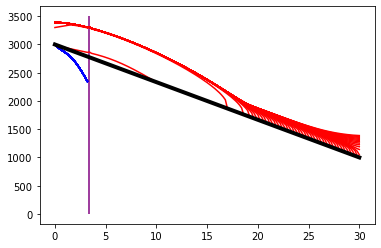

In [12]:
# Run
if use_M2 == 1:
    M2()
    p1, = plt.plot(0,0, '-r')
    p2, = plt.plot(0,0, '-b')
    #cProfile.run("M2()")
if use_M3 == 1:
    M3()
    p2, = plt.plot(0,0, '-m')
    #cProfile.run("M2()")
if use_upstream == 1:
    lengthup = []
    volumeup = []
    SurfaceElevationup = []
    upstream()
    p3, = plt.plot(0,0, '-g')
    #cProfile.run("upstream()")
if use_MUSCL == 1:
    lengthM = []
    volumeM = []
    SurfaceElevationM = []
    MUSCL()
    p4, = plt.plot(0,0, '-b')
    #cProfile.run("MUSCL()")
p5, = plt.plot(x/1000,B, '-k', linewidth = 4)
p6, = plt.vlines(x[Nxt]/1000, ymin = 0, ymax = 3500,
               colors = 'purple')
#p6, = plt.plot(x/1000,S_exp, color='#ff7800', linewidth = 4)
plt.xlabel('x (km)')
plt.ylabel('Height (m)')
plt.legend([p1, p2, p6],["M2","M2 Tributary", "Tributary merge point"])
plt.title("Tributary, 1000 years of evolution")
plt.savefig('Glacier Model')

In [ ]:
#plots
if plt_TEL == 1:
    if use_MUSCL == 1:
        plt.plot(yrs, lengthM, label = 'My model MUSCL')
    if use_upstream == 1:
        plt.plot(yrs, lengthup, label = 'My model Upstream')
    plt.xlabel('Years Model ran')
    plt.ylabel('Glacier Length')
    plt.legend()
    plt.show()
if plt_TEV ==1:
    if use_MUSCL == 1:
        plt.plot(yrs, volumeM, label = 'My model MUSCL')
    if use_upstream == 1:
        plt.plot(yrs, volumeup, label = 'My model Upsteam')
    plt.xlabel('Years Model ran')
    plt.ylabel('Glacier Volume (km3)')
    plt.legend()
    plt.show()
if plt_SE ==1:
    if use_MUSCL == 1:
        plt.plot(x,SurfaceElevationM, label = 'My model MUSCL')
    if use_upstream == 1:
        plt.plot(x,SurfaceElevationup, label = 'My model Upsteam')
    plt.plot(x,B, '-k', linewidth = 4)
    plt.xlabel('Distance from Glacier head')
    plt.ylabel('Glacier Surface Elevation')
    plt.legend()
    plt.show()

In [ ]:

#S=np.zeros(Nx) #Initial conditions
#S[x<x_s]=b_0
#for n in range(0, timesteps-1):
#    U = []
#    # set deltat
#    if use_E==1:
#        deltat = dx/2
#    if use_TVD==1 or use_nTVD==1:
#        deltat = (dx/2)/np.amax(np.abs(u))
#    
#    # Calculate u1
#    if use_TVD==1 or use_nTVD==1:
#        for j in range(2, Nx-2):
#            # caluculate the j-1/2 index
#            u_min_up = u_min(u[j-1][n], u[j][n], u[j+1][n])
#            u_plus_up = u_plus(u[j][n],u[j+1][n], u[j+2][n])
#        
#            # calculate the j+1/2 index
#            u_min_down = u_min(u[j-2][n], u[j-1][n], u[j][n])
#            u_plus_down = u_plus(u[j-1][n], u[j][n], u[j+1][n])
#        
#            # calculate f (numerical flux)
#            f_plus = h(u_min_up, u_plus_up)
#            f_min = h(u_min_down, u_plus_down)
#        
#            # Calculate L
#            Lu = L(f_plus, f_min)
#        
#            if use_TVD ==1:
#                u1[j][n] = TVDu1(u[j][n], Lu, deltat)
#            if use_nTVD ==1:
#                u1[j][n] = nTVDu1(u[j][n], Lu, deltat)
#            #print(u1[j][n])
#            
#    for j in range(2, Nx-2):
#        if use_TVD==1 or use_nTVD==1:
#            # To calculate L1 you need to calculate f off the u1 values
#            # calculate the j-1/2
#            u1_min_up = u_min(u1[j-1][n], u1[j][n], u1[j+1][n])
#            u1_plus_up = u_plus(u1[j][n],u1[j+1][n], u1[j+2][n])
#        
#            # calculate the j+1/2 index
#            u1_min_down = u_min(u[j-2][n], u1[j-1][n], u1[j][n])
#            u1_plus_down = u_plus(u[j-1][n], u1[j][n], u1[j+1][n])
#            
#            # calculate f1
#            f1_plus = h(u1_min_up, u1_plus_up)
#            f1_min = h(u1_min_down, u1_plus_down)
#            
#            # calculate L1
#            L1 = L(f1_plus, f1_min)
#         
#        # calculate u
#        # calculate the j-1/2 index
#        u_min_up = u_min(u[j-1][n], u[j][n], u[j+1][n])
#        u_plus_up = u_plus(u[j][n],u[j+1][n], u[j+2][n])
#        
#        # calculate the j+1/2 index
#        u_min_down = u_min(u[j-2][n], u[j-1][n], u[j][n])
#        u_plus_down = u_plus(u[j-1][n], u[j][n], u[j+1][n])
#        
#        # calculate f (numerical flux)
#        f_plus = h(u_min_up, u_plus_up)
#        f_min = h(u_min_down, u_plus_down)
#        
#        # Calculate L
#        if use_E==1:
#            Lu = Lbar(f_plus, f_min)
#        if use_TVD==1 or use_nTVD==1:
#            Lu = L(f_plus, f_min)
#        
#        if use_E==1:
#            unplus = E(u[j][n],Lu, deltat) #equation 1.10 (Gottlieb 1998)
#        if use_TVD==1:
#            unplus = TVD(u[j][n], Lu, L1, deltat) #equation 2.4 (Gottlieb 1998)
#        if use_nTVD ==1:
#            unplus = nTVD(u[j][n], Lu, L1, deltat) #equation 2.5 (Gottlieb 1998)
#            
#        u[j][n+1] = unplus
#        
#        U.append(u[j][n])    
#    #print(U)
#            
#plt.plot(xx,U)
#plt.plot(x/1000,B,'-k',linewidth=2)